Motivation

Can we build a personal fitness model based on running tracking data that helps identify strategy gaps, overtraining etc.. and recommend future workouts that are fine tuned for a goal such as faster pace? That explains my high level curiousity.

Can we build a deep learing model, when fed historical tracking data, such as heart rate and other attributes available from wearables, learns relevant features and can be used for recommendations?

Let's narrow down our problem to explore what's possible. Can we build a deep learning model/classifier, that, given a time-series of heart-rate data of a run, predicts the category of it? 

Fastai

We'll use fastai library to develop the model.

pyts

pyts is a wonderful python package for timeseries classification. We'll use this together with Fastai



In [1]:
#hide
!pip install -Uqq fastbook
import fastbook

# setup also mounts gdrive at /content/gdrive
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.7MB/s 
     |████████████████████████████████| 194kB 16.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 16.4MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
Mounted at /content/gdrive


In [2]:
# for various timeseries ML apis.
!pip install pyts

# for gpx file parsing.
!pip install gpxpy

nb_root = '/content/gdrive/MyDrive/Colab Notebooks'

     |████████████████████████████████| 2.5MB 8.3MB/s 
     |████████████████████████████████| 112kB 7.5MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.4.2-cp36-none-any.whl size=42547 sha256=57fc603e18b3c4ec5e93cdb3a533175a757c37f5b19bb974757d448e97a0a0dd
  Stored in directory: /root/.cache/pip/wheels/d9/df/ed/b52985999b3967fa0ef8de22b3dc8ad3494ce3380d5328dd0f
Successfully built gpxpy


Timeseries and Deep Learning

A neat idea is presented in fastbook and fastai course. classification of time-series data can be done using deeplearning, if the input dataset can be converted to an image. Then, we can use cnn based models. A cool technique exists to represent time-series data as an image called Gramian Angular Field. Pyts documentation is an excellent and concise primer on this technique. Let's think about it in the context of our data - heart rate information.



Heart rate monitors save heart-rate(an integer value) every few(eg: 5) seconds during the course of a run which gets saved to a file. For our exploration, we'll use gpx files exported from garmin-connect. More on this later. We can extract heart-rate for a run into a list, ordered chronologically, from start of the run to finish. A typical run may have anywhere between a few hundred data-points to several thousand depending on the length of a run.

Let's consider a toy example first, consisting of just 4 data-points.

In [87]:
# test example of a heart rate timeseries consisting of only 4 data-points.
eg_hr = [75, 100, 105, 180]

print('Example heart rate time-series - {}'.format(eg_hr))

Example heart rate time-series - [75, 100, 105, 180]


Representing this information as GAF and hence an image is a 3 step process

In [88]:
# step 1: scale the timeseries to (-1, 1) range. Here, let's do (0, 1) range.
scale_range = (0, 1)
min_hr = min(eg_hr)
max_hr = max(eg_hr)
eg_hr_scaled = [(scale_range[0] + (scale_range[1] - scale_range[0]) * ((e - min_hr)/(max_hr - min_hr))) for e in eg_hr]

print('heart rate scaled to [0,1] range - {}'.format(eg_hr_scaled))

heart rate scaled to [0,1] range - [0.0, 0.23809523809523808, 0.2857142857142857, 1.0]


Note that after scaling, the smallest heart rate(75) became 0 and the largest(180) became 1 and everything in between is scaled appropriately. The advantage of scaling (0, 1) instead of (-1, 1) is that we can accurately convert the data back. More on why this may matter later.

In [89]:
# step 2: compute arccos/inverse-cosine values corresponding to eg_hr_scaled. These values let us imagine angles made by individual heart rate data points, in a vector space.
eg_hr_angles = np.arccos(eg_hr_scaled)

print('inverse cosine values of scaled data - {}'.format(eg_hr_angles))

inverse cosine values of scaled data - [1.57079633 1.33039211 1.28104463 0.        ]


In [92]:
# step 3: final step to get the gramian-summation-matrix. compute cosine of sum of each pair of heart rates. We can imagine this as the distance spanned by a pair of heart rate datapoints together. This captures the temporal relation between two given data points.
gasf = np.cos(np.add.outer(eg_hr_angles, eg_hr_angles))

# alt step 3: final step to get the gramian-difference-matrix. compute sine of the difference between...
gadf = np.sin(np.subtract.outer(eg_hr_angles, eg_hr_angles))
print('gasf\n{}\n\ngadf\n{}'.format(gasf, gadf))

gasf
[[-1.00000000e+00 -9.71241812e-01 -9.58314847e-01  6.12323400e-17]
 [-9.71241812e-01 -8.86621315e-01 -8.62728238e-01  2.38095238e-01]
 [-9.58314847e-01 -8.62728238e-01 -8.36734694e-01  2.85714286e-01]
 [ 6.12323400e-17  2.38095238e-01  2.85714286e-01  1.00000000e+00]]

gadf
[[ 0.          0.23809524  0.28571429  1.        ]
 [-0.23809524  0.          0.04932746  0.97124181]
 [-0.28571429 -0.04932746  0.          0.95831485]
 [-1.         -0.97124181 -0.95831485  0.        ]]


Let's only focus on GASF variant moving forward. When we train, we may want to consider the difference matrix as well as it captures ... More on the coolness of GAF technique later.

But first, let's visualize our toy example

In [3]:
%matplotlib inline

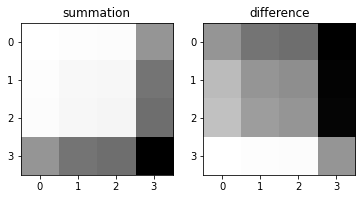

In [95]:
plt.axis('off')

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('summation')
plt.imshow(gasf, cmap='Greys', origin='upper')

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('difference')
plt.imshow(gadf, cmap='Greys', origin='upper')

Recap

With this toy example, I want to details the steps involved in transforming our input. We'll be using pyts to all of this and more magically for us with real data. But we can highlight some observations clearly from the toy example

Monotonic pattern

If you trace the diagonal from top left to bottom right on the summation image, the gray scale goes from white to black, capturing the monotonous pattern in our data where heart-rate increases over time - [75, 100, 105, 180]

Temporal pattern

The temporal distance between two data-points is simply the pixel distance. t0 is the [0,0] index, t1 is [1,1] and so on. But also, the cool thing is that we capture the correlation in heart rate between say t0 and t1 in [0,1]. By the change in color, we can say that the heart rate did not jump. Where as, it's clear that it jumped between t2 and t3 (105 -> 180). I need to explain this better..

More observations... later. Let's visualize a real example.

In [4]:
from fastai.vision.all import *
from fastbook import *

In [5]:
import gpxpy

# returns an array of heart rate recordings for each point saved in the gpx file.
# @TODO: for multivariate case(eg: [hr, elevation, temp]), we can return a np array of vectors.
# @TODO: ditch gpx and parse tcx files if that provides more datapoints for multivariate case
def get_hr_data(gpx_file_path):
  gpx = gpxpy.parse(open(gpx_file_path))
  hr_data = []
  for track in gpx.tracks:
    for segment in track.segments:
      for point in segment.points:
        for extension in point.extensions:
          # other dimensions(eg: elevation, temp) may be part of the point or extension element.
          for elem in extension:
            if elem.tag.endswith('hr'):
              hr_data.append(int(elem.text))
  return np.array((hr_data,))



In [132]:
# 1. read a gpx file and extract hr into an array
# 2. create gaf(sum and diff) images (also markov ones eventually)
# 3. plot the hr and gaf images
# 4. save gafs to files
# 5. Save PAA and other future work as cells with notes

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField

def load_gaf(hr_data, method, image_size=1., sample_range=(0,1)):

  # Transform the time series into Gramian Angular Fields
  # @TODO: try PAA. What's the performance hit? Is it worth it for upto few 1000 points and say, a few 1000 samples?.
  # Is it bijective - can we reverse to orignal input image? - would be useful for model understanding.
  gasf = GramianAngularField(image_size=image_size, sample_range=sample_range, method=method)
  return gasf.fit_transform(hr_data)

def load_gasf(hr_data, image_size=1., sample_range=(0,1)):
  return load_gaf(hr_data, method='summation', image_size=image_size, sample_range=sample_range)

def load_gadf(hr_data, image_size=1., sample_range=(0,1)):
  return load_gaf(hr_data, method='difference', image_size=image_size, sample_range=sample_range)

def show_images(sf, df, idx=0):

  # Show the images for the first time series
  fig = plt.figure(figsize=(8, 4))
  grid = ImageGrid(fig, 111,
                  nrows_ncols=(1, 2),
                  axes_pad=0.15,
                  share_all=True,
                  cbar_location="right",
                  cbar_mode="single",
                  cbar_size="7%",
                  cbar_pad=0.3,
                  )
  images = [sf[idx], df[idx]]
  titles = ['Summation', 'Difference']
  for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
  ax.cax.colorbar(im)
  ax.cax.toggle_label(True)
  plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
  plt.show()

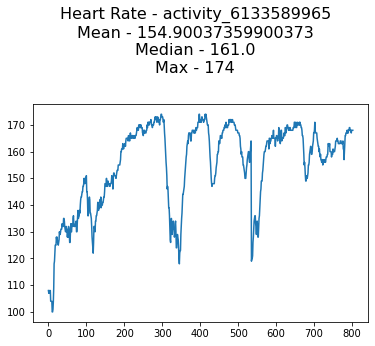

In [106]:
# Let's load my friend Dre's sample
dre_gpx = Path(nb_root, "gpxfiles", "activity_6133589965.gpx")

dre_gpx

dre_hr_data = get_hr_data(dre_gpx)

dre_hr_mean = np.mean(dre_hr_data[0])
dre_hr_median = np.median(dre_hr_data[0])

plt.plot(dre_hr_data[0])
plt.suptitle('Heart Rate - {}\nMean - {}\nMedian - {}\nMax - {}'.format(dre_gpx.stem, dre_hr_mean, dre_hr_median, np.max(dre_hr_data[0])), y=0.98, fontsize=16, va='bottom')
plt.show()

Some observations to highlight

* There is a overall trend of increasing heart rate from beginning to the end
* There are a few sudden dips and spikes suggesting a interval type workout
* Average heart rate indicates this may be categorized as a Zone4(154.9/190 = .81%)
* Median heart rate indicates this may be categorized as a Zone4(161/190 = .84)

Now, let's visualize the GAF images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


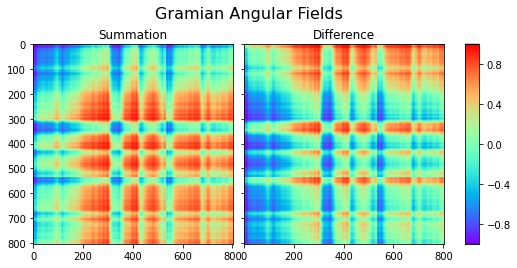

In [111]:
dre_gasf = load_gasf(dre_hr_data)
dre_gadf = load_gadf(dre_hr_data)

fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [dre_gasf[0], dre_gadf[0]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='upper')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

Let's focus on the Summation image. There are around 800 heart-rate observations. Tracing the diagonal from top left to bottom right, blue at the beginning indicates lower heart-rate and more and more red towards the end of the diagonal indicates higher heart-rate. The size and transition-suddenness between blue blotches and orange/redish ones indicates the interval training pattern of this workout.

More on sideways patterns and those from difference image... later.

For now, I am energized by the results so far and eager to build our first classifier.

Our real dataset

To build the model, I am going to use a subset my personal data that I have saved over the last couple of years. Things can really get out of hand, so I want to be very specific in creating the dataset and formulating the problem.

* A little over 100 samples. Each sample is a gpx file containing heart-rate timeseries data.
* About half of the samples are my usual 5-mile loop I call 5SL. Each of these samples is about X timeseries datapoints.
* The other half are my usual 7-mile loop I call 7OL. About Y timeseries datapoints.
* A lot of these runs are probably Z4 and the remaining Z3. I need to look at the distribution, but perhaps not evenly distributed.

Problem formulation

There are two problems that seem like good candidates to build a classifier.
1. use (5SL, 7OL) as classes. Given a sample, predict if it's a 5-mile loop or a 7-mile loop.
2. use (Z3, Z4) as classes and predict the heart-rate zone of a given sample.

Let's work on the first problem.

For now, I haven't figured out a way to represent gafs as images without having to save them to disk. I think there are some drawbacks to this, but I'll worry about them later.

In [6]:
from pathlib import Path
gpx_root = Path(nb_root, 'gpxfiles')
png_root = Path(nb_root, 'pngfiles')

In [18]:
def save_png(parent_dir, gaf_img, cmap, method, filename):
  plt.figure(figsize=(8, 8))
  plt.imshow(gaf_img, cmap=cmap, origin='upper')

  plt.axis('off')
  plt.savefig(Path(parent_dir, '{0}-{1}'.format(filename, method)), transparent=True, bbox_inches='tight', pad_incues=0, )
  plt.close()

def save_gafs(method, input_path, output_path, show=False):
  
  file_list = [f for f in os.listdir(input_path) if f.endswith('.gpx')]

  for f in file_list:
    fp = Path(input_path, f)
    filename = fp.stem
    
    hr_data = get_hr_data(fp)
    gaf = load_gaf(hr_data, method, sample_range=(-1,1))

    save_png(output_path, gaf[0], "rainbow", method, filename)
    print('Saved {}'.format(filename))
  


In [ ]:
save_gafs('summation', gpx_root, png_root)

In [28]:
def is_SL(x):
  return x.find('5SL') > -1

dls = ImageDataLoaders.from_name_func(png_root, get_image_files(png_root), valid_pct=0.2, seed=42, label_func=is_SL, bs=16, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75))

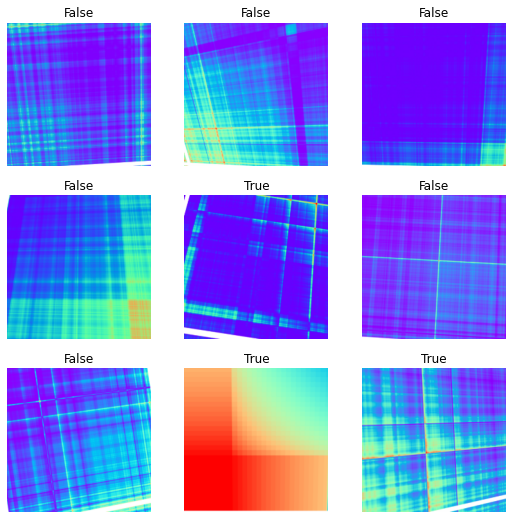

In [29]:
# TODO: open issue for "this dataloader doesn't contain any batches" error. At the very least, error message can be better/actionable.
dls.show_batch()

In [32]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.048801,1.055840,0.523810,00:25


epoch,train_loss,valid_loss,error_rate,time
0,1.109678,0.724945,0.428571,00:32
1,1.172708,0.820616,0.428571,00:32
2,0.984909,0.813838,0.428571,00:32
3,0.973356,0.865735,0.476190,00:32
4,0.935136,0.732521,0.333333,00:32
5,0.936068,0.838644,0.333333,00:32
6,0.883206,1.092174,0.380952,00:32
7,0.882372,1.017813,0.285714,00:32
8,0.841912,1.080862,0.285714,00:32
9,0.758929,1.046241,0.380952,00:32


In [31]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.101292,0.689669,0.476190,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.976533,0.819983,0.523810,00:31
1,0.892360,0.836412,0.523810,00:31
2,0.994644,1.476326,0.523810,00:31
3,0.941313,1.702338,0.571429,00:31
4,0.839595,1.623793,0.476190,00:31
5,0.848237,1.505917,0.380952,00:31


In [25]:
learn.fit

epoch,train_loss,valid_loss,error_rate,time
0,0.686607,1.222500,0.380952,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.854673,1.076823,0.428571,00:43
1,0.821141,0.705577,0.285714,00:43
2,0.858229,1.663467,0.619048,00:43
3,0.885640,1.134896,0.476190,00:43
4,0.818559,0.825609,0.428571,00:43
5,0.794535,1.009630,0.380952,00:43


AttributeError: ignored

In [159]:
learn.predict(PILImage.create('/content/gdrive/MyDrive/Colab Notebooks/npyfiles/valid/5SL/5SL_08252020-summation.png'))

('True', tensor(1), tensor([0.0036, 0.9964]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


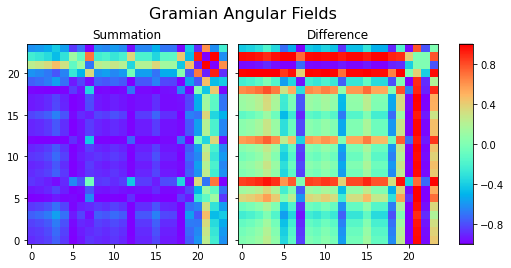

In [37]:
# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=24, method='summation')
hr_data_gasf = gasf.fit_transform(hr_data)
gadf = GramianAngularField(image_size=24, method='difference')
hr_data_gadf = gadf.fit_transform(hr_data)

# Show the images for the first time series
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [hr_data_gasf[0], hr_data_gadf[0]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

In [1]:
# Lets create training and validation datasets
# two classification problems I can think of. Need to examine the dataset to see if both make sense.
# First: two possible labels - 7OL, 5SL. This is a simple problem and we should have enough data. Not a very interesting problem but great to focus on setting up the whole pipeline and not worry about solving a richer problem for now.
# Second: label each datapoint by heart-rate zone.

# Let's look at the distribution of data before chosing one of the above two possibilities as the first problem to solve.

# There are 53 OL runs and coincidentally, 53 SL runs :) A total of 106 datapoints. We can do 80/20 split. So that will be 42 training images in each category. Should be plenty to go ahead with the first category/problem formulation.



42.400000000000006

References

https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3

pyts website.

polar coordinates refresher: https://www.khanacademy.org/math/multivariable-calculus/integrating-multivariable-functions/double-integrals-a/v/polar-coordinates-1
